In [1]:
# import statements
import pandas as pd
import numpy as np
from IPython.display import clear_output
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from collections import Counter
from google.colab import files
import io

In [ ]:
# download nltk package
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Obtain data from github repository

In [ ]:
data_url = 'https://raw.githubusercontent.com/owl0108/MAIS202-Final-Project/master/data/train.tsv'
org_df = pd.read_table(data_url)
# display
org_df.iloc[:20]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


# List of helper functions for preprocessing

In [ ]:
def clean(review):
  '''(str) -> str
  Remove punctuation, numbers
  '''
  review = review.lower() # lowercase
  review = re.sub("[^A-Za-z ]", '', review) #remove non-alphabetic characters but preserve apostrophe
  return review

In [ ]:
def convert_tag(tag):
  '''(str) -> str
  Convert tags associated by nltk.pos_tag into the format which lemmatizer.lemmatize understands
  Used in lemmatize() function
  '''
  if tag.startswith('V'): string = 'v'
  elif tag.startswith('J'): string = 'a'
  elif tag.startswith('R'): string = 'r'
  else: string = 'n'
  return string

In [ ]:
# tokenization and clean each token
def tokenize(review):
  '''(str) -> list
  Tokenize the given string: convert it into list of words.
  '''
  tokenized = word_tokenize(review)
  tagged = nltk.pos_tag(tokenized)
  new_tokenized = list()
  
  # clean() is applied after tokenization to split shortend words properly
  # If clean() is applied before tokenization, "I'm" becomes "Im" and will be stored as one token.
  for word in tokenized:
    new_tokenized.append(clean(word))
  return new_tokenized

In [ ]:
# remove stop words
def rmv_stopwd(tokenized):
  '''(list) -> list
  From the list of words, remove the stop words provided by nltk library.
  '''
  stop_list = stopwords.words('english')
  return [word for word in tokenized if word not in stop_list]

In [ ]:
def lemmatize(tokenized):
  '''(list) -> list
  Given the list of words, lemmatize each word in the list and return a new list.
  Depending on the result of lemmatization, duplicates of the same word may exist in the returned list.
  '''
  tagged = nltk.pos_tag(tokenized)
  lemmatizer = WordNetLemmatizer() 
  lmt = list()
  for word, tag in tagged:
    new_tag = convert_tag(tag)
    lemmatized = lemmatizer.lemmatize(word, pos=new_tag)
    lmt.append(lemmatized)
  return lmt

In [ ]:
def get_vacab(review):
  '''(str) -> list
  Given string, the function returns the list of words appearing in the given string.
  '''
  tokenized = tokenize(review)
  tokenized = rmv_stopwd(tokenized)
  tokenized = list(filter(None, tokenized))
  tokenized = lemmatize(tokenized)

  return tokenized

In [ ]:
def get_bow(review_vocab, feature_vocab):
  '''(list, list) -> list
  Given the list of words(=vocabulary), the function returns binary-bag-of-words.
  '''
  bow_list = list()
  for word in feature_vocab:
    if word in review_vocab:
      bow_list.append(1)
    else:
      bow_list.append(0)
  return bow_list

## Create model_vocab in order to create BoW expression.

## Limit BoW size to 3000 to avoid crashing

In [ ]:
# create vocabulary for the entire dataset and create FreqDist
# len(freq) is 13648
processed = get_vocab(data_df.Phrase.str.cat(sep=' '))
freq = nltk.FreqDist(processed)

# choose the length of BoW
freq = freq.most_common(3000)

# create model_vocab
model_vocab = list()
for word, num in freq:
  model_vocab.append(word)

In [ ]:
def get_BoW(review):
  '''(str) -> np.array
  Takes string as input and returns a BoW expression
  '''
  vocab = get_vocab(review)
  return np.array(get_bow(vocab, model_vocab)).reshape(1,-1)



## create vocabulary for each row

In [ ]:
%%time
data_df = org_df
review_ser = data_df.Phrase
count = 0
# make a new column
data_df['vocabulary'] = ''
for i, review in enumerate(review_ser):
  data_df.at[i, 'vocabulary'] = get_vocab(review)
  clear_output()
  print(count)
  count += 1

156059
CPU times: user 11min 40s, sys: 1min 10s, total: 12min 51s
Wall time: 16min 7s


## Create BoW for each row

In [ ]:
%%time
count = 1
# creat bag-of-word for each row
vocab_ser = data_df.vocabulary
# make a new column
data_df['BoW'] = ''
for i, vocab in enumerate(vocab_ser):
  data_df.at[i, 'BoW'] = get_bow(vocab, model_vocab)
  clear_output()
  print(count)
  count += 1

156060
CPU times: user 7min 31s, sys: 54.5 s, total: 8min 26s
Wall time: 9min 58s


## Saving preprocessed data

In [ ]:
# data_df.to_pickle(path='/content/drive/My Drive/MAIS202/BoW3000_large2.pkl')

## Import preprocessed data

In [3]:
import_df = pd.read_pickle('/content/drive/My Drive/MAIS202/Final_result/BoW3000_final.pkl')

## Reduce the imbalance of training data

In [4]:
# much more instances of sentiment = 2
# we'll reduce the number of instances with sentiment = 2 to 30000
import_df.groupby('Sentiment').count()

,PhraseId,SentenceId,Phrase,vocabulary,BoW
Sentiment,,,,,
0,7072,7072,7072,7072,7072
1,27273,27273,27273,27273,27273
2,79582,79582,79582,79582,79582
3,32927,32927,32927,32927,32927
4,9206,9206,9206,9206,9206


In [5]:
temp_df = import_df[import_df.Sentiment == 2].reset_index().reset_index().loc[:, ['level_0', 'index']].rename({'level_0':'2_count'}, axis=1)
temp_df

,2_count,index
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
...,...,...
79577,79577,156053
79578,79578,156054
79579,79579,156055
79580,79580,156058


In [6]:
data_df = pd.merge(import_df, temp_df, how='left', left_index=True, right_on='index').drop('index', axis=1).reset_index(drop=True).fillna(-1)
data_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,vocabulary,BoW,2_count
0,1,1,A series of escapades demonstrating the adage ...,1,"[series, escapades, demonstrating, adage, good...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...",-1.0
1,2,1,A series of escapades demonstrating the adage ...,2,"[series, escapades, demonstrating, adage, good...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.0
2,3,1,A series,2,[series],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
3,4,1,A,2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.0
4,5,1,series,2,[series],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.0


In [7]:
# reduce the number of instances with sent=2
# shaffle rows
data_df = data_df[data_df.loc[:, '2_count'] < 30000].sample(frac=1)

In [8]:
# 106478 rows
data_df.groupby('Sentiment').count()

,PhraseId,SentenceId,Phrase,vocabulary,BoW,2_count
Sentiment,,,,,,
0,7072,7072,7072,7072,7072,7072
1,27273,27273,27273,27273,27273,27273
2,30000,30000,30000,30000,30000,30000
3,32927,32927,32927,32927,32927,32927
4,9206,9206,9206,9206,9206,9206


### Change data type (dataframe to numpy array)

In [9]:
bow_arr = data_df.BoW.explode().to_numpy().reshape((-1, 3000))

In [10]:
sen_arr = data_df.Sentiment.explode().to_numpy()

### Create train, validation, and test datasets

In [11]:
# split dataset into 3
x_tr = bow_arr[:70000]
x_vld = bow_arr[70000:85000]
x_test = bow_arr[85000:]
y_tr = sen_arr[:70000]
y_vld = sen_arr[70000:85000]
y_test = sen_arr[85000:]

# Training Step

In [12]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import joblib

In [13]:
def check_accuracy(pred, true_val, v_max):
  print('Accuracy score: ', accuracy_score(true_val, pred))
  print('Mean squared error: ', ((true_val - pred)**2).mean())

  # confusioin matrix
  print("\nConfusion matrix: ")
  print("x_label: predicted    y_label: known")
  cm = confusion_matrix(true_val, pred)
  print("\n", cm, "\n")
  sns.heatmap(cm, cmap="Blues", vmax=v_max)

## Multinomial Naive Bayes

In [14]:
%%time
clf = MultinomialNB()
clf.fit(x_tr,y_tr)

CPU times: user 6.66 s, sys: 39.4 ms, total: 6.7 s
Wall time: 6.15 s


Accuracy score:  0.4786
Mean squared error:  0.9721333333333333

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 195  546  128  111    5]
 [ 154 1973  728  942   24]
 [  18  732 1499 1904   22]
 [  17  476  794 3170  245]
 [   2   53   86  834  342]] 



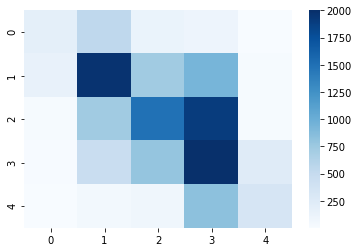

In [15]:
y_pred = clf.predict(x_vld)
check_accuracy(y_pred, y_vld, 2000)

## Complementary Naive Bayes

In [16]:
%%time
clf_compNB = ComplementNB()
clf_compNB.fit(x_tr,y_tr)

CPU times: user 6.69 s, sys: 39.2 ms, total: 6.73 s
Wall time: 6.16 s


Accuracy score:  0.43
Mean squared error:  1.4982

Confusion matrix: 
x_label: predicted    y_label: known

 [[ 317  521   70   51   26]
 [ 745 2071  407  457  141]
 [1095  903 1023  900  254]
 [ 436  572  493 2548  653]
 [  40   53   47  686  491]] 



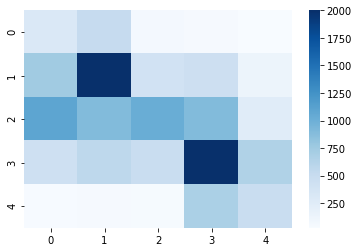

In [17]:
y_pred = clf_compNB.predict(x_vld)
check_accuracy(y_pred, y_vld, 2000)

### Output trained model and model_vacab

In [20]:
#joblib.dump(model_vocab, "/content/drive/My Drive/MAIS202/Final_result/model_vocab.pkl")
joblib.dump(clf, "/content/drive/My Drive/MAIS202/Final_result/multi_NB.pkl")

['/content/drive/My Drive/MAIS202/Final_result/multi_NB.pkl']